# Location analysis of _wayang kulit_ performances in Java

By Miguel Escobar Varela.

This is the companion code to Chapter 4 of my book _Theater as data: Computational Journeys into theater research_ (University of Michigan Press, 2021).

The book is openly accessible at https://doi.org/10.3998/mpub.11667458.

### *About Juypter and Python*

The following is written as a step-by-step tutorial for users who want to reproduce the results presented in my book.

This is an interactive Jupyter Notebook. For users not familiar with Python and Jupyter I recommend 
Allen Downey's excellent introductory materials at https://allendowney.github.io/ElementsOfDataScience/.

### 1 Importing the relevant libraries

First, we import [Pandas](https://pandas.pydata.org/) to read the data into dataframes, as well as [Seaborn](https://seaborn.pydata.org/) and [Matplotlib](https://matplotlib.org/) for the visualizations. For this project we will also need [NumPy](https://numpy.org/about/) for numerical computing. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

The analysis carried out here also requires the Python Spatial Analysis Library (PySAL) package, which can be downloaded from [here](https://pysal.org/install).

***Note**. Tho original code in the book's website used PySAL version 1.14.4, which requires many dependencies that are difficult to install. In 2024, I refactored the code to use a more recent version of the package (4.12.1), which requires an entirely different syntax.

In [6]:
import pysal as ps
from libpysal.weights import Queen, lag_spatial
from esda.moran import Moran

### 2 Importing the data

We will use the **7.3_performancePerRegency.csv** file included under the book's data at Fulcrum.

This file includes the average number of performance for each regency in Java, Indonesia, between 2016 and 2019.

The data was obtained from [Kluban](http://kluban.net). I used the Python [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) package to scrap the website and then format the results into a CSV file. For more on the context of this research project see Chapter 7 of _Theater as Data_.

With the following code, we will read the CSV file into a data frame called **df**. The syntax assumes that the CSV is under a directory called **data/ch7**.

In [2]:
df = pd.read_csv("../../data/ch7/7_3_performancesPerRegency.csv")

To get a sense of the data, we can use the **head()** function to display the first 5 rows of the dataframe.

In [3]:
df.head()

,regency,performances
0,Boyolali,165
1,Blitar_Kota,0
2,Malang_Kota,15
3,Blora,88
4,Sleman,177


We can set "regency" as the index of this dataframe.

In [4]:
df.set_index("regency",inplace=True)

### 3 Calculating Moran's _I_

Our objective is to determine whether geographical proximity affects a given variable (the number of performances). As described in Chapter 6 of _Theater as Data_ this is called _spatial autocorrelation_. The most common statistic used for this purpose is Moran’s _I_ (Moran 1948), which estimates the probability that a value for a geographical unit is affected by the average value of neighboring units.

To figure this out, we need a list that includes all neighbors for each regency. Neighbors are defined here as those regions which border the regency in question. Using a nomenclature borrowed from chess, this is called *queen contiguity* (as opposed to *bishop contiguity*). To calculate this we can use the function **queen_from_shapefile()** from PySAL. Using this function we load the Java shapefile (also available via Fulcrum) and assign it to a variable called **queen**.

***Note**. For the shapefile to be loaded correctly all the files under the **java/** folder in Fulcrum need to be in the folder, not just java.shp.

In [7]:
queen = Queen.from_shapefile("../../data/ch7/java/java.shp")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/io/iohandlers/pyShpIO.py:247: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  shp = self.type(vertices)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/shapes.py:1408: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._part_rings = [Ring(vertices)]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/io/iohandlers/pyShpIO.py:232: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  shp = self.type(vertices, holes)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/shapes.py:1405: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of

To combine this contiguity matrix with the performance data, we first need to rotate the matrix using **.transform = 'r'**

In [8]:
queen.transform = 'r'

The next step is to calculate the spatial lag for the total number of performances using the **lag_spatial()** function from PySAL.

In [12]:
perf = df.performances
perf_lag = lag_spatial(queen, perf)

As explained in Chapter 7 of *Theater as Data*, Moran's *I* can be understood as the slope of the regression line between the number of performances and the spatial lag of this variable. To visualize this line, we can use NumPY to calculate a polynomial fitting line for the number of perfornaces (**perf**) and it's spatial lag (**perf_lag**).

In [15]:
b,a = np.polyfit(perf, perf_lag, 1)

In [16]:
print(a,b)

108.88339226330983 0.17333687206403506


In [17]:
print(a,b)

108.88339226330983 0.17333687206403506


**a** gives us the "y intercept" of this line, and **b** its slope (which is equivalent to Moran's *I*).

To better understand this, we can generate a scatterplot of the number of performances and their spatial lag, and overlay the polynomial fitting line on top of this scatterplot.

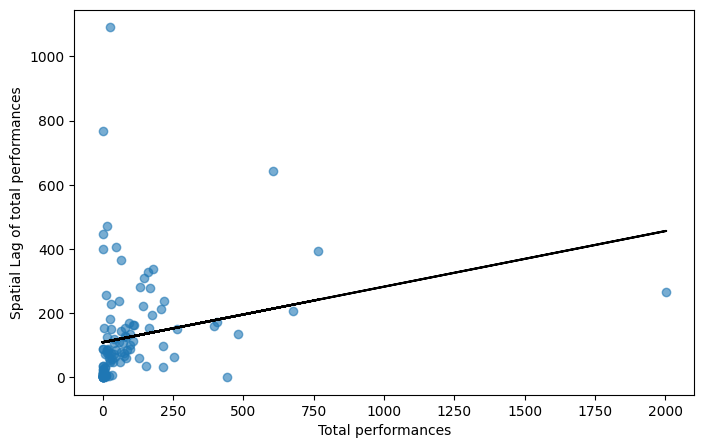

In [19]:
f, ax = plt.subplots(1,figsize=(8, 5))

#the dots in the scatterplot, with a transparency of alpha = 0.6
plt.plot(perf, perf_lag, 'o', alpha=0.6)

#the regression line
plt.plot(perf, a + b*perf,"black",linestyle="-")

#the labels
plt.ylabel('Spatial Lag of total performances')
plt.xlabel('Total performances')
plt.show()

We can also calculate Moran's I directly from PySAL, using the **Moran()** function.

In [21]:
I_perf = Moran(perf, queen)

We can inspect the _I_ value with the following instruciton:

In [23]:
I_perf.I

0.17333687206403495

As we can see, this is the same value as the regression line, which we calculated above.

In addition to the _I_ value, PySAL, also gives us a _p_-value. This is obtained from a series of 999 simulations based on the existing data, so it can be more accurately described as a *pseudo p*-value. To display this value, we can use **.p_sim**.

In [24]:
I_perf.p_sim

0.003

***Note**. Since this is based on simulations, the actual value might change slightly when run in a different computer, and it might be slightly different from what is reported in *Theater as Data*, but it should be reasonably close to that number.

We can also manually inspect all the _I_ values generated during the simulations, with **.sim**.

In [25]:
I_perf.sim

array([-3.70122078e-02,  2.89719460e-02,  1.48393309e-02,  3.39678160e-02,
       -4.81568644e-02,  4.95232444e-02, -7.00790797e-03,  5.43297868e-02,
       -3.29529602e-02, -5.51273239e-02, -1.69739955e-02, -4.27213028e-02,
        9.20201869e-03, -3.59152905e-02,  1.88113051e-03, -1.99127494e-02,
       -7.53386650e-03, -1.59693405e-02, -5.27190932e-02, -7.88261643e-02,
       -1.96740500e-03,  1.51793395e-02, -1.88291189e-02,  1.23502752e-01,
        7.00184652e-02,  1.02681820e-01,  5.03035096e-02, -1.81287072e-02,
       -4.16056694e-02, -4.00584587e-02,  1.12801389e-02,  6.63328292e-02,
       -5.94814234e-02,  6.45104567e-02, -5.19224383e-02, -1.83161159e-03,
        2.68708207e-02, -7.34008308e-02,  3.84421750e-02, -6.02440591e-02,
       -2.95933975e-02, -6.10522752e-03,  4.84313510e-03,  2.15024693e-02,
       -2.41930958e-02, -3.59813709e-02, -9.22919026e-03,  2.59488420e-02,
       -3.59326137e-05,  1.26766529e-01, -6.62985968e-02, -3.48715283e-02,
       -2.47799132e-02, -

To make better sense of these values, we can use Seaborn to visualize them in a Kernel Density Estimate (kde) plot (see Chapter 6 of *Theater as Data* for more on KDEs). We can also overlay the actual *I* as a dotted line on top of this plot to get a better sense of what the *pseudo p-*value indicates (i.e., how "rare" the obseved value is in relation to the simulated values). 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 11.0)

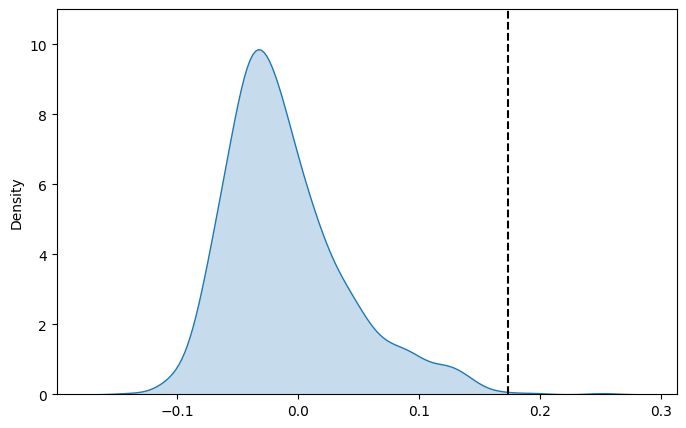

In [26]:
ax, fig = plt.subplots(1, figsize=(8, 5))
sns.kdeplot(I_perf.sim, fill=True)
plt.vlines(I_perf.I, 0, 11, 'black',"--")
plt.ylim([0,11])